# Demo for ISPC.jl

Runs the Mandelbrot ISPC example entirely from Julia code.

In [1]:
using ISPC

Linker: /usr/bin/libtool


This is the function we will call for every pixel. Declare it `@inline` so that the `@kernel` below can use it.

In [2]:
@inline function mandel(c_re, c_im, count)
    z_re = c_re
    z_im = c_im
    i = 0
    while i < count
        if (z_re * z_re + z_im * z_im > 4.0f0)
            break
        end
        new_re = z_re*z_re - z_im*z_im
        new_im = 2.0f0 * z_re * z_im
        z_re = c_re + new_re
        z_im = c_im + new_im
        i += 1
    end
    return i
end

mandel (generic function with 1 method)

This is the main function. Tag it with `@ispc` so that all kernel fragments inside are extracted and compiled separately by ISPC.

In [3]:
@ispc function mandelbrot_ispc(x0, y0, x1, y1, output, max_iters)
    height, width = size(output)
    dx = (x1 - x0) / width
    dy = (y1 - y0) / height
    @kernel(`--target=avx1-i32x8`) do
        for i = 1:width
            @foreach(1:height) do j
                x = x0 + i * dx
                y = y0 + j * dy
                output[j,i] = mandel(x, y, max_iters)
            end
        end
    end
    output
end;

Extracted kernel Val{symbol("##8014")}((:x0,:y0,:output,:max_iters,:height,:width,:dx,:dy))
begin 
    GenSym(3) = (Main.colon)(1,width)
    #s40 = (top(start))(GenSym(3))
    unless (top(!))((top(done))(GenSym(3),#s40)) goto 1
    2: 
    GenSym(4) = (top(next))(GenSym(3),#s40)
    i = (top(getfield))(GenSym(4),1)
    #s40 = (top(getfield))(GenSym(4),2)
    $(Expr(:meta, :ispc, symbol("##foreach#8022"), :foreach, (:(1:height),)))
    j = (ISPC.foreachindex)(1,(Main.colon)(1,height))
    x = ((top(getfield))(Base.FastMath,:add_fast))(x0,((top(getfield))(Base.FastMath,:mul_fast))(i,dx))
    y = ((top(getfield))(Base.FastMath,:add_fast))(y0,((top(getfield))(Base.FastMath,:mul_fast))(j,dy))
    GenSym(5) = (Main.mandel)(x,y,max_iters)
    (Main.setindex!)(output,GenSym(5),j,i)
    $(Expr(:meta, :ispc, symbol("##foreach#8022")))
    3: 
    unless (top(!))((top(!))((top(done))(GenSym(3),#s40))) goto 2
    1: 
    0: 
    return
end


In [4]:
output = zeros(Float32, 768, 1024);

Check that kernel fragments in the main Julia function have been replaced by kernel calls:

In [5]:
@code_lowered mandelbrot_ispc(-2.0f0, -1.0f0, 1.0f0, 1.0f0, output, 256)

1-element Array{Any,1}:
 :($(Expr(:lambda, Any[:x0,:y0,:x1,:y1,:output,:max_iters], Any[Any[Any[:x0,:Any,1],Any[:y0,:Any,1],Any[:x1,:Any,0],Any[:y1,:Any,0],Any[:output,:Any,1],Any[:max_iters,:Any,1],Any[:height,:Any,19],Any[:width,:Any,19],Any[symbol("#s41"),:Any,2],Any[:dx,:Any,19],Any[:dy,:Any,19]],Any[],6,Any[]], :(begin  # In[3], line 2:
        NewvarNode(:height)
        NewvarNode(:width)
        NewvarNode(:dx)
        NewvarNode(:dy)
        GenSym(0) = (Main.size)(output)
        #s41 = (top(start))(GenSym(0))
        GenSym(1) = (top(indexed_next))(GenSym(0),1,#s41)
        height = (top(getfield))(GenSym(1),1)
        #s41 = (top(getfield))(GenSym(1),2)
        GenSym(2) = (top(indexed_next))(GenSym(0),2,#s41)
        width = (top(getfield))(GenSym(2),1)
        #s41 = (top(getfield))(GenSym(2),2) # In[3], line 3:
        dx = (x1 - x0) / width # In[3], line 4:
        dy = (y1 - y0) / height # In[3], line 5: # /Users/plantagenet/.julia/v0.5/ISPC.jl/src/macros.jl, line 141:

Calling the main function the first time will trigger the compilation of all its fragments:

In [6]:
mandelbrot_ispc(-2.0f0, -1.0f0, 1.0f0, 1.0f0, output, 256);

Generating kernel ##8014 for argument types (Float32,Float32,Array{Float32,2},Int64,Int64,Int64,Float32,Float32)
Compile options: `--target=avx1-i32x8`
Running type inference...
Lambda function:
	 arguments: Any[:x0,:y0,:output,:max_iters,:height,:width,:dx,:dy]
	 local variables: 
		(symbol("#s40"),Int64,2)
		(:i,Int64,18)
		(:j,Int64,18)
		(:x,Float32,18)
		(:y,Float32,18)
		(:x0,Float32,0)
		(:y0,Float32,0)
		(:output,Array{Float32,2},0)
		(:max_iters,Int64,0)
		(:height,Int64,18)
		(:width,Int64,18)
		(:dx,Float32,18)
		(:dy,Float32,18)
		(symbol("##zs#8510"),Tuple{},0)
		(symbol("##zs#8511"),Tuple{},0)
		(symbol("##z_re#8512"),Float32,2)
		(symbol("##z_im#8513"),Float32,2)
		(symbol("##i#8514"),Int64,2)
		(symbol("##new_re#8515"),Float32,18)
		(symbol("##new_im#8516"),Float32,18)
		(symbol("####xs#8509#8517"),Tuple{},0)
		(symbol("##I#8518"),Tuple{},0)
	 closure variables: 

	 SSA types: Any[Union{},Union{},Union{},UnitRange{Int64},Tuple{Int64,Int64},Int64,Int64,Int64]
	 parameter

ld: warning: -macosx_version_min not specified, assuming 10.10


Loaded function ispc_func_1 at Ptr{Void} @0x000000030ec987c0


Now let's call it again to get an accurate measure of execution time:

In [15]:
x0, x1 = -2.1f0, 0.8f0
y0, y1 = -1.2f0, 1.2f0
@time out = mandelbrot_ispc(x0, y0, x1, y1, output, 256);

  0.091577 seconds (15 allocations: 352 bytes)


Plot the generated fractal:

In [16]:
using PyPlot

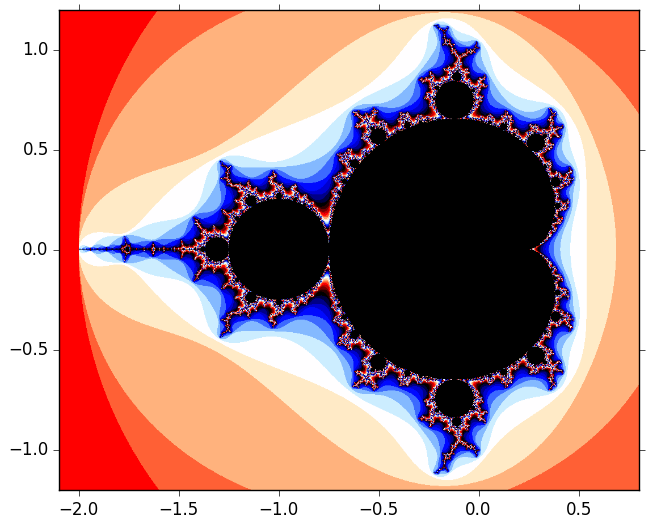

In [17]:
imshow(out, cmap="flag", aspect="equal", extent=(x0, x1, y0, y1))
display(gcf())
close()

Wow, nice!

Pure-Julia version for comparison. Note how it uses the same `mandel()` routine as the ISPC version. We can't use `@simd` here because of the branch statements.

In [26]:
@fastmath function mandelbrot_julia(x0, y0, x1, y1, output, max_iters)
    height, width = size(output)
    dx = (x1 - x0) / width
    dy = (y1 - y0) / height
    @inbounds begin
        for i = 1:width
            for j = 1:height
                x = x0 + i * dx
                y = y0 + j * dy
                output[j, i] = mandel(x, y, max_iters)
            end
        end
    end
    output
end

mandelbrot_julia (generic function with 1 method)

How fast does it run?

In [28]:
@time out = mandelbrot_julia(x0, y0, x1, y1, output, 256);

  0.233861 seconds (4 allocations: 160 bytes)


Not bad, only about 2.5x to 3x slower. But we got a decent speedup from ISPC!

Let's look at the generated C code, x86 assembly and LLVM assembly.

In [22]:
func = ISPC.ispc_funcs[1];

In [23]:
func_code = ISPC.gen_code(func)
println(func_code)

// Use ISPC's multiple dispatch capabilities to deal with the fact
// that Julia uses the same function for bitwise and boolean NOT,
// whereas the ~ operator in ISPC does not work on booleans:
inline bool __not(bool val) {return !val;} // boolean NOT
inline int8 __not(int8 val) {return ~val;} // all others are bitwise
inline int16 __not(int16 val) {return ~val;}
inline int32 __not(int32 val) {return ~val;}
inline int64 __not(int64 val) {return ~val;}
inline unsigned int8 __not(unsigned int8 val) {return ~val;}
inline unsigned int16 __not(unsigned int16 val) {return ~val;}
inline unsigned int32 __not(unsigned int32 val) {return ~val;}
inline unsigned int64 __not(unsigned int64 val) {return ~val;}


struct UnitRange {
    int64 start;
    int64 stop;
};
export void ispc_func_1(uniform float x0, uniform float y0, uniform float output[], uniform int64 output__len__1, uniform int64 output__len__2, uniform int64 max_iters, uniform int64 height, uniform int64 width, uniform float dx, uniform

In [24]:
ISPC.ispc_native(func_code, func.file.compile_opts)

	.section	__TEXT,__text,regular,pure_instructions
	.macosx_version_min 13, 4
	.section	__TEXT,__literal16,16byte_literals
	.align	4
LCPI0_0:
	.long	0                       ## 0x0
	.long	1                       ## 0x1
	.long	2                       ## 0x2
	.long	3                       ## 0x3
LCPI0_1:
	.long	4                       ## 0x4
	.long	5                       ## 0x5
	.long	6                       ## 0x6
	.long	7                       ## 0x7
LCPI0_2:
	.byte	0                       ## 0x0
	.byte	1                       ## 0x1
	.byte	4                       ## 0x4
	.byte	5                       ## 0x5
	.byte	8                       ## 0x8
	.byte	9                       ## 0x9
	.byte	12                      ## 0xc
	.byte	13                      ## 0xd
	.byte	8                       ## 0x8
	.byte	9                       ## 0x9
	.byte	12                      ## 0xc
	.byte	13                      ## 0xd
	.byte	12                      ## 0xc
	.byte	13                      ## 0xd
	.byt

2328

cklps	%xmm14, %xmm14, %xmm4 ## xmm4 = xmm14[0,0,1,1]
	vunpckhps	%xmm14, %xmm14, %xmm6 ## xmm6 = xmm14[2,2,3,3]
	vinsertf128	$1, %xmm6, %ymm4, %ymm4
	vextractf128	$1, %ymm14, %xmm6
	vblendvps	%ymm4, %ymm0, %ymm7, %ymm7
	vunpcklps	%xmm6, %xmm6, %xmm0 ## xmm0 = xmm6[0,0,1,1]
	vunpckhps	%xmm6, %xmm6, %xmm4 ## xmm4 = xmm6[2,2,3,3]
	vinsertf128	$1, %xmm4, %ymm0, %ymm0
	vblendvps	%ymm0, %ymm3, %ymm2, %ymm2
	vandnps	%ymm1, %ymm12, %ymm14
LBB0_45:                                ## %for_test516.outer
                                        ##   Parent Loop BB0_2 Depth=1
                                        ## =>  This Loop Header: Depth=2
                                        ##       Child Loop BB0_46 Depth 3
	vmovups	%ymm10, 320(%rsp)       ## 32-byte Spill
	vmovups	%ymm11, 352(%rsp)       ## 32-byte Spill
	vmulps	%ymm10, %ymm10, %ymm10
	vmulps	%ymm11, %ymm11, %ymm9
	vaddps	%ymm10, %ymm9, %ymm15
	.align	4, 0x90
LBB0_46:                                ## %for_test516
                      

In [25]:
ISPC.ispc_llvm(func_code, func.file.compile_opts)

; ModuleID = '<stdin>'
target datalayout = "e-m:o-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-apple-darwin13.4.0"

; Function Attrs: nounwind readnone
declare i32 @llvm.x86.avx.movmsk.ps.256(<8 x float>) #0

; Function Attrs: nounwind
declare void @llvm.x86.avx.maskstore.ps.256(i8*, <8 x float>, <8 x float>) #1

; Function Attrs: nounwind readnone
declare <8 x float> @llvm.x86.avx.blendv.ps.256(<8 x float>, <8 x float>, <8 x float>) #0

; Function Attrs: nounwind
define void @ispc_func_1___unfunfun_3C_unf_3E_unIunIunIunIunIunfunf(float %x0, float %y0, float* noalias nocapture %output, i64 %output__len__1, i64 %output__len__2, i64 %max_iters, i64 %height, i64 %width, float %dx, float %dy, <8 x i32> %__mask) #1 {
allocas:
  %floatmask.i = bitcast <8 x i32> %__mask to <8 x float>
  %v.i = tail call i32 @llvm.x86.avx.movmsk.ps.256(<8 x float> %floatmask.i) #0
  %cmp.i = icmp eq i32 %v.i, 255
  %lessequal__width_load = icmp sgt i64 %width, 0
  %width.op = add i64 %width, 1
  %a

2328

put__len__1_load_sub_i_load115_
  %add_mul_output__len__1_load_sub_i_load115__broadcast_smear_counter49_cast_cast.elt0 = trunc i64 %add_mul_output__len__1_load_sub_i_load115__broadcast_smear_counter49_cast.elt0 to i32
  %shl_add_mul_output__len__1_load_sub_i_load115__broadcast_smear_counter49_cast_cast_.elt0 = shl i32 %add_mul_output__len__1_load_sub_i_load115__broadcast_smear_counter49_cast_cast.elt0, 2
  %"varying+const_offsets.elt0" = add i32 %shl_add_mul_output__len__1_load_sub_i_load115__broadcast_smear_counter49_cast_cast_.elt0, -4
  %0 = sext i32 %"varying+const_offsets.elt0" to i64
  %ptr = getelementptr i8* %output_load_ptr2int_2void, i64 %0, !filename !2, !first_line !3, !first_column !4, !last_line !3, !last_column !5
  %ptrcast = bitcast i8* %ptr to <8 x float>*
  store <8 x float> %_gensym5_load_to_float, <8 x float>* %ptrcast, align 4, !filename !2, !first_line !3, !first_column !4, !last_line !3, !last_column !5
  %new_counter = add i32 %counter.1799, 8
  %before_aligned